In [3]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [5]:
SAVE_PATH = "../output/github_experiments"
DATA_PATH = "../data/github.gml"

### Util functions

In [44]:
def get_exp_params(save_path, exp_name):
    with open(os.path.join(save_path, exp_name, "embedder_params.json"), "r") as f:
        params = json.load(f)
    return params

def get_exp_target_results(save_path, exp_name) -> pd.DataFrame:
    results = pd.read_csv(os.path.join(save_path, exp_name, "target_metrics.csv"))
    return results

def get_exp_baseline_results(save_path, exp_name) -> pd.DataFrame:
    results = pd.read_csv(os.path.join(save_path, exp_name, "base_metrics.csv"))
    return results

# Link prediction - cut ratio : 10%

In [67]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T14-55-53_0", "cora_deepwalk_k_core_2020-02-19T15-00-27_0", "cora_deepwalk_k_core_2020-02-19T15-05-42_0", "cora_deepwalk_k_core_2020-02-19T15-09-13_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

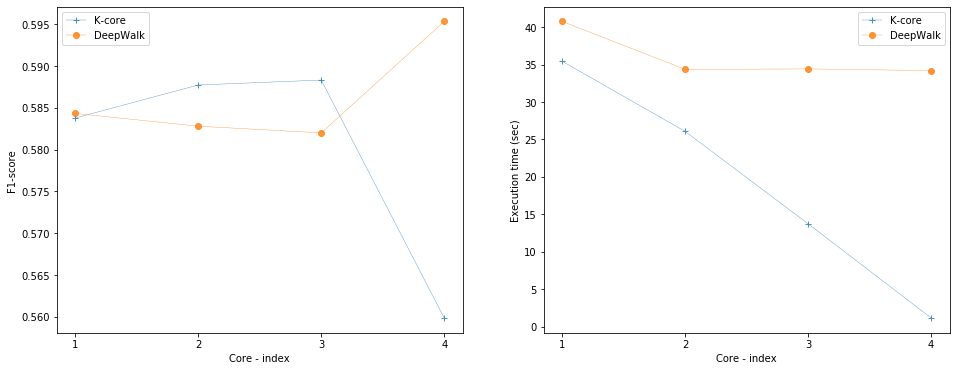

In [90]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(core_index, target_f1_score, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_f1_score, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.subplot(1, 2, 2)

plt.plot(core_index, target_exec_time, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_exec_time, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.show()


## Embedding

In [98]:
def get_embedding(save_path, exp_name):
    base_embedding_path = os.path.join(os.path.join(save_path, exp_name), "embeddings/embeddings_base_0.pkl")
    target_embedding_path = os.path.join(os.path.join(save_path, exp_name), "embeddings/embeddings_target_0.pkl")

    with open(base_embedding_path, "rb") as fin:
        base_emb = pkl.load(fin)

    with open(target_embedding_path, "rb") as fin:
        target_emb = pkl.load(fin)
        
    return target_emb, base_emb

In [154]:
def plot_emb_core(vectors, id2node, core_numbers, min_core=0, max_core=1000):
    pca = PCA(n_components=2)
    projected_vectors = pca.fit_transform(vectors)
    id2core = [core_numbers[node] for node in id2node if min_core <= core_numbers[node] <= max_core]    
    to_be_plot = np.array([vector for i, vector in enumerate(projected_vectors) if min_core <= core_numbers[id2node[i]] <= max_core])
    plt.scatter(to_be_plot.T[0], to_be_plot.T[1], marker='.', alpha=0.5, 
               c=id2core) , cmap="plasma")
    plt.colorbar()

In [155]:
def plot_emb_core_class(vectors, id2node, core_numbers, min_core=0, max_core=1000):
    labels_dict = graph.nodes.data()
    pca = PCA(n_components=2)
    projected_vectors = pca.fit_transform(vectors)
    labels = [labels_dict[node]["community"] for node in id2node if min_core <= core_numbers[node] <= max_core]    
    to_be_plot = np.array([vector for i, vector in enumerate(projected_vectors) if min_core <= core_numbers[id2node[i]] <= max_core])
    plt.scatter(to_be_plot.T[0], to_be_plot.T[1], marker='.', alpha=0.5, 
               c=labels) #, cmap="plasma")
    # plt.colorbar()

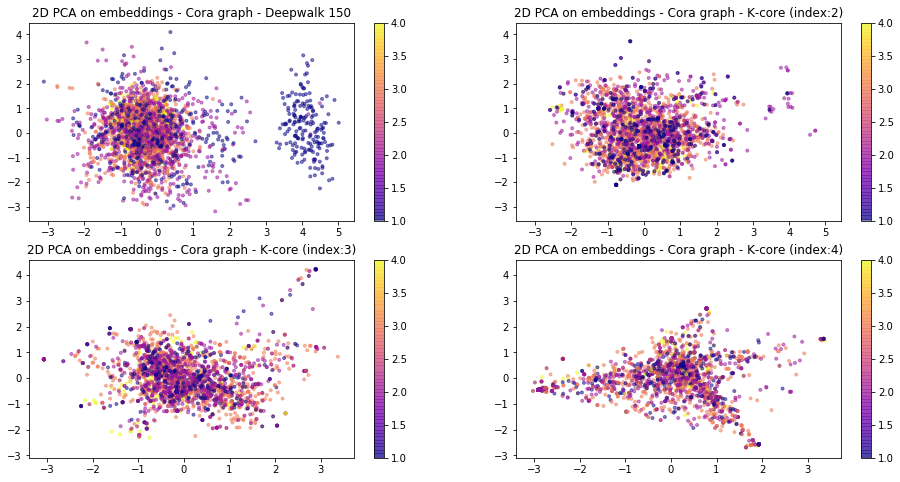

In [118]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

# Link prediction - Cut ratio 30%

In [176]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T16-14-20_0", "cora_deepwalk_k_core_2020-02-19T16-18-52_0", "cora_deepwalk_k_core_2020-02-19T16-22-17_0", "cora_deepwalk_k_core_2020-02-19T16-24-34_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

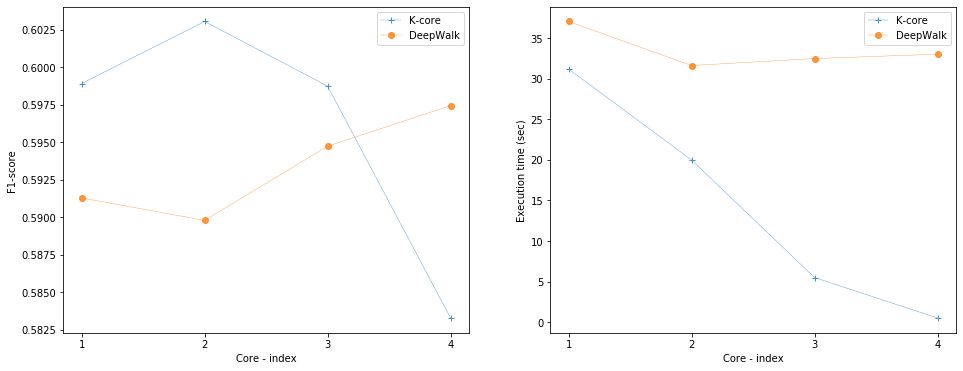

In [177]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(core_index, target_f1_score, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_f1_score, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.subplot(1, 2, 2)

plt.plot(core_index, target_exec_time, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_exec_time, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.show()

# Node classification

In [122]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T15-32-25_0", "cora_deepwalk_k_core_2020-02-19T15-43-16_0", "cora_deepwalk_k_core_2020-02-19T15-46-47_0", "cora_deepwalk_k_core_2020-02-19T15-49-38_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

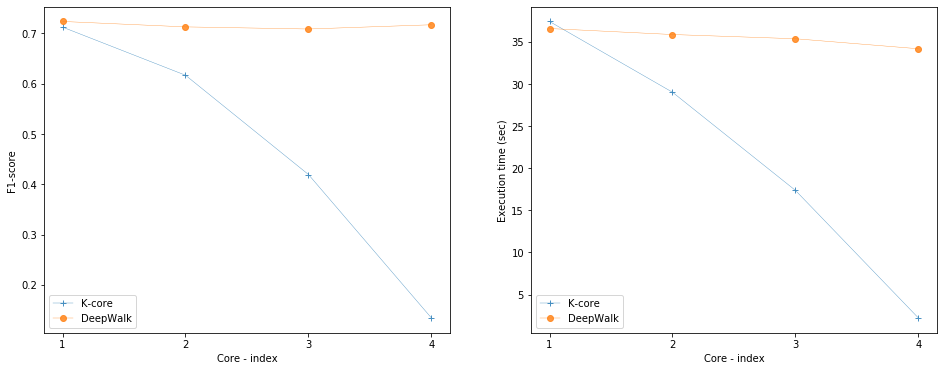

In [123]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(core_index, target_f1_score, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_f1_score, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("F1-score")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.subplot(1, 2, 2)

plt.plot(core_index, target_exec_time, marker="+", alpha=.8, lw=.4, label = "K-core")
plt.plot(core_index, baseline_exec_time, marker="o", alpha=.8, lw=.4, label = "DeepWalk")
plt.ylabel("Execution time (sec)")
plt.xlabel("Core - index")
plt.legend()
plt.xticks(core_index)

plt.show()

## Embedding

In [125]:
exp_names = ["cora_deepwalk_k_core_2020-02-19T15-32-25_0", "cora_deepwalk_k_core_2020-02-19T15-43-16_0", "cora_deepwalk_k_core_2020-02-19T15-46-47_0", "cora_deepwalk_k_core_2020-02-19T15-49-38_0"]

core_index = []
target_f1_score = []
baseline_f1_score = []
target_exec_time = []
baseline_exec_time = []

for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    target_results = get_exp_target_results(SAVE_PATH, exp_name)
    baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)
    
    core_index.append(params["train"]["core_index"])
    target_f1_score.append(target_results["macro_f1"].mean())
    target_exec_time.append(target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())
    baseline_f1_score.append(baseline_results["macro_f1"].mean())
    baseline_exec_time.append(baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean())

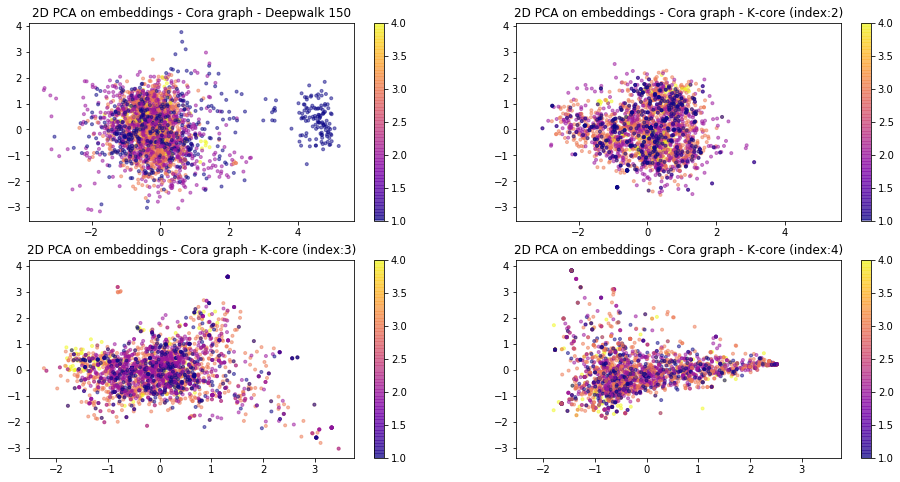

In [126]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

In [ ]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

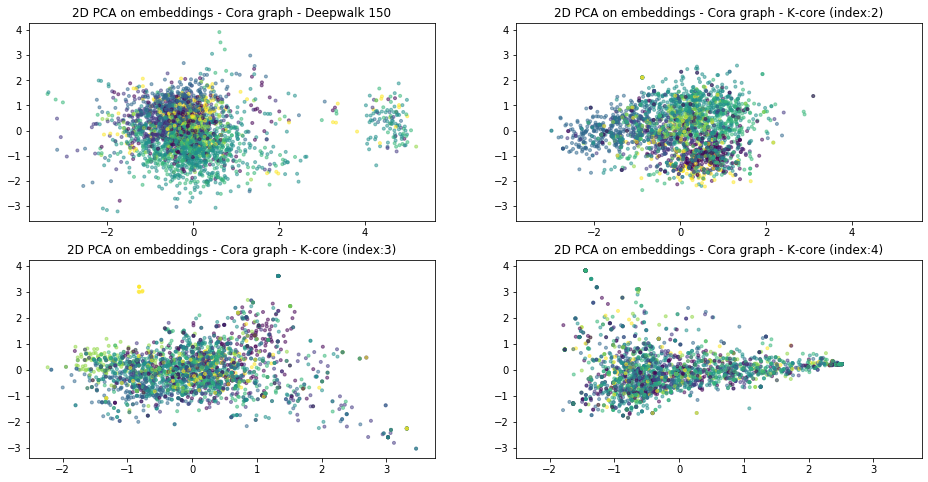

In [156]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
graph = nx.read_gml(DATA_PATH)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []
for exp_name in exp_names :
    params = get_exp_params(SAVE_PATH, exp_name)
    core_index.append(params["train"]["core_index"])
    target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
    target_emb_list.append(target_emb)
    base_emb_list.append(base_emb)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[1].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[1]))
ax = plt.subplot(223)
vectors, node2id, id2node = target_emb_list[2].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[2]))
plt.subplot(224, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb_list[3].values()
plot_emb_core_class(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - K-core (index:{})".format(core_index[3]))
plt.show()

# The famous road graph dataset

In [159]:
exp_name = "roads_20000_deepwalk_corewalk_linear_2020-02-19T14-50-44_0"
params = get_exp_params(SAVE_PATH, exp_name)
target_results = get_exp_target_results(SAVE_PATH, exp_name)
baseline_results = get_exp_baseline_results(SAVE_PATH, exp_name)

In [169]:
target_results

,out_dim,exec_times,n_walks,walk_length,window_size,n_generated_walks,micro_f1,macro_f1,accuracy,tot_exec_time
0,150,"{'k_core_decomposition': 0.13666868209838867, ...",15,30,5,168965,0.558883,0.558873,0.558883,282.934879
1,150,"{'k_core_decomposition': 1.8296782970428467, '...",15,30,5,169170,0.557257,0.557221,0.557257,282.934879
2,150,"{'k_core_decomposition': 1.8606634140014648, '...",15,30,5,170365,0.557227,0.557215,0.557227,282.934879


In [170]:
baseline_results

,out_dim,exec_times,n_walks,walk_length,window_size,n_generated_walks,micro_f1,macro_f1,accuracy,tot_exec_time
0,150,"{'generate_walks': 168.15657019615173, 'skip_g...",15,30,5,300000,0.540763,0.540760,0.540763,467.934357
1,150,"{'generate_walks': 154.0339035987854, 'skip_gr...",15,30,5,300000,0.545344,0.545339,0.545344,467.934357
2,150,"{'generate_walks': 138.56184124946594, 'skip_g...",15,30,5,300000,0.549483,0.549419,0.549483,467.934357


In [168]:
target_results["tot_exec_time"] = target_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean()
baseline_results["tot_exec_time"] = baseline_results["exec_times"].apply(lambda time_dict : eval(time_dict)["total"]).mean()

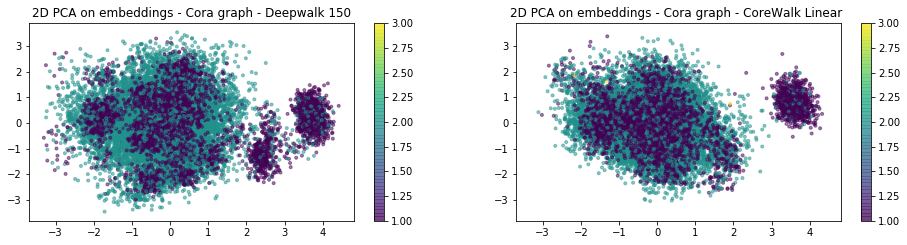

In [175]:
target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)
DATA_PATH_ = "../data/roads_20000.gml"
graph = nx.read_gml(DATA_PATH_)
core_numbers = nx.core_number(graph)

core_index = []
target_emb_list, base_emb_list = [], []

target_emb, base_emb = get_embedding(SAVE_PATH, exp_name)

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
vectors, node2id, id2node = base_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)  #, min_core=0, max_core=114)
plt.title("2D PCA on embeddings - Cora graph - Deepwalk 150")
plt.subplot(222, sharex=ax, sharey=ax)
vectors, node2id, id2node = target_emb.values()
plot_emb_core(vectors, id2node, core_numbers, min_core=0)
plt.title("2D PCA on embeddings - Cora graph - CoreWalk Linear ")
plt.show()